<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="33%"/>
  </p>
  
# **Trabajo Práctico 1: Reservas de Hotel**
### **Checkpoint**: 3
### **Grupo**: 11 - Los Pandas
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo
### **Integrantes**:
### 103456 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

# Ensambles: Random Forest

### Carga inicial de dependencias y datos

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
import dtreeviz
import warnings

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

# Aclaración:
# Hay un warning que puede llegar a aparecer que es debido a una actualización interna de Seaborn que será deprecada, para solucionarlo hay que modificar el código de python
# directamente (lo cual no es una buena práctica).
# La función en concreto se va a seguir utilizando, por lo que no afecta a nuestro código en sí, si no al comportamiento interno de dicha función.
# Se propone ignorar dicho warninig, ya que se solucionará en la próxima versión de Python
# En el siguiente enlace se puede encontrar más información:
# https://github.com/ultralytics/ultralytics/issues/4729
# https://github.com/mwaskom/seaborn/issues/3462
#
# se puede ignorar descomentando las siguientes líneas

warnings.filterwarnings('ignore', 'is_categorical_dtype is deprecated')
warnings.filterwarnings("ignore", "use_inf_as_na")

# o bien otra solución (más elegante), es obtener dicha actualización corriendo esta línea:
# pip install -U ultralytics

In [2]:
hotels_df = pd.read_csv('hotels_train.csv')
hotels_df_backup = hotels_df.copy()
hotels_df_mod = hotels_df.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)

hotels_df_mod = hotels_df_mod.dropna(subset=['country', 'distribution_channel', 'market_segment'])

hotels_df_mod['required_car_parking_spaces'] = hotels_df_mod['required_car_parking_spaces'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['required_car_parking_spaces'] = hotels_df_mod['required_car_parking_spaces'].astype(bool)

hotels_df_mod['days_in_waiting_list'] = hotels_df_mod['days_in_waiting_list'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['days_in_waiting_list'] = hotels_df_mod['days_in_waiting_list'].astype(bool)

hotels_df_mod['babies'] = hotels_df_mod['babies'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['babies'] = hotels_df_mod['babies'].astype(bool)

hotels_df_mod['previous_cancellations'] = hotels_df_mod['previous_cancellations'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['previous_cancellations'] = hotels_df_mod['previous_cancellations'].astype(bool)

hotels_df_mod['total_of_special_requests'] = hotels_df_mod['total_of_special_requests'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['total_of_special_requests'] = hotels_df_mod['total_of_special_requests'].astype(bool)

hotels_df_mod['previous_bookings_not_canceled'] = hotels_df_mod['previous_bookings_not_canceled'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['previous_bookings_not_canceled'] = hotels_df_mod['previous_bookings_not_canceled'].astype(bool)

hotels_df_mod['booking_changes'] = hotels_df_mod['booking_changes'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['booking_changes'] = hotels_df_mod['booking_changes'].astype(bool)
hotels_df_mod = hotels_df_mod.drop(hotels_df_mod[hotels_df_mod['adults'] > 4].index)

hotels_df_mod['agent'] = hotels_df_mod['agent'].astype(str)
hotels_df_mod['agent'] = hotels_df_mod['agent'].replace('nan', 'Undefined')

# renombrar columna del dataframe de reserved_room_type a room_type_match
hotels_df_mod = hotels_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

hotels_df_mod.loc[hotels_df_mod['room_type_match'] == hotels_df_mod['assigned_room_type'], 'room_type_match'] = True
hotels_df_mod.loc[hotels_df_mod['room_type_match'] != hotels_df_mod['assigned_room_type'], 'room_type_match'] = False

hotels_df_mod['room_type_match'] = hotels_df_mod['room_type_match'].astype(bool)

In [4]:
hotels_df = hotels_df_mod.copy()
hotels_df_backup = hotels_df.copy()

In [5]:
#One hot encoding para variables categoricas
hotels_df_x = pd.get_dummies(hotels_df, columns=["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type", "customer_type", "agent" ], drop_first=True)

#Creo un dataset con los features que voy a usar para clasificar
hotels_df_x = hotels_df_x.drop(['is_canceled'], axis='columns')

hotels_df_x = hotels_df_x.reindex(sorted(hotels_df_x.columns), axis=1)

#Creo un dataset con la variable target
hotels_df_y = hotels_df['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(hotels_df_x,
                                                    hotels_df_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

tree_model = tree.DecisionTreeClassifier()

## Se varían los hiperparámetros

Para elegir los mejores hiperparámetros se decidió iterar de manera parecida a una búsqueda binaria. Se decidió variarlos utilizando una búsqueda en grilla, dado a que realizando un barrido lineal y luego realizar uno nuevo sobre el mejor intervalo encontrado se cree que se tendrán mejores valores que buscando al azar. También se creé que de esta manera se tardará menos al mismo tiempo que se analizarán solo los puntos más importantes.

Primero se buscó el mejor *max_depth*, luego el mejor criterio, luego los *min_samples_split* y *min_samples_leaf* y por último se realizó una búsqueda logarítmica para el mejor alpha.

Se obtuvo que los mejores hiperparámetros (utilizando el F1 score como métrica) para este caso son:

- *ccp_alpha* = $10^{-4,42}$
- Criterio = Gini
- *max_depth* = 16
- *min_samples_split* = 2
- *min_samples_leaf* = 2
- *folds* = 16

Siendo el F1 score = 0,8452

In [16]:
params_grid = {'criterion':['gini'],
               'ccp_alpha': np.logspace(-4.4, -4.6, 10),
               'max_depth':[16],
               'random_state': [2]}

folds=10

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )


model = gridcv.fit(x_train,y_train)

print(gridcv.best_params_)
print(gridcv.best_score_)

{'ccp_alpha': 3.7824899063893825e-05, 'criterion': 'gini', 'max_depth': 16, 'random_state': 2}
0.8428866197113228


## Predicción sobre el conjunto test_data de hotels_train con el mejor modelo obtenido

In [19]:
params_grid = {'criterion':['gini'],
               'ccp_alpha': [10**(-4.42)],
               'max_depth':[16],
               'random_state': [2]}

folds=16
kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )

model = gridcv.fit(x_train,y_train)

In [20]:
model.best_estimator_.get_params()

{'ccp_alpha': 3.8018939632056124e-05,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 16,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 2,
 'splitter': 'best'}

In [21]:
#Realizamos una predicción sobre el set de test
y_pred = model.predict(x_test)
#Valores Predichos
y_pred

#Valores Reales
y_test.values

#Probemos verlos juntos en un DataFrame
ds_resultados=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
ds_resultados.head(10)

,test,pred
0,1,0
1,0,0
2,1,1
3,1,1
4,0,0
5,1,1
6,1,1
7,0,0
8,1,1
9,1,1


Text(50.722222222222214, 0.5, 'True')

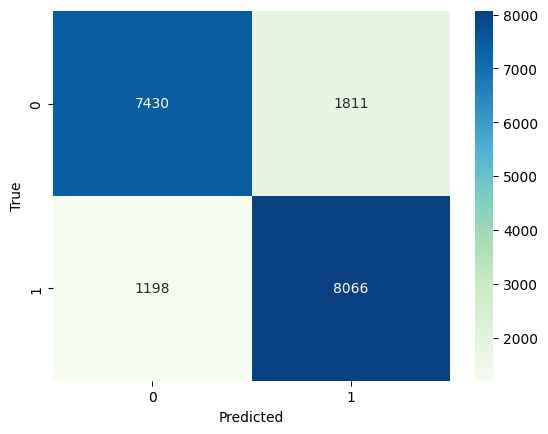

In [22]:
tabla=confusion_matrix(y_test, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [23]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

print(classification_report(y_test,y_pred))

Accuracy: 0.8373952985679546
Recall: 0.8706822107081175
Precision: 0.8166447301812291
f1 score: 0.8427981819131707
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      9241
           1       0.82      0.87      0.84      9264

    accuracy                           0.84     18505
   macro avg       0.84      0.84      0.84     18505
weighted avg       0.84      0.84      0.84     18505



## Se predice hotels_test

In [27]:
test_df = pd.read_csv('hotels_test.csv')

test_df_mod = test_df.copy()

test_df_mod['required_car_parking_spaces'] = test_df_mod['required_car_parking_spaces'].apply(lambda x: True if x >= 1 else False)
test_df_mod['required_car_parking_spaces'] = test_df_mod['required_car_parking_spaces'].astype(bool)

test_df_mod['days_in_waiting_list'] = test_df_mod['days_in_waiting_list'].apply(lambda x: True if x >= 1 else False)
test_df_mod['days_in_waiting_list'] = test_df_mod['days_in_waiting_list'].astype(bool)

test_df_mod['babies'] = test_df_mod['babies'].apply(lambda x: True if x >= 1 else False)
test_df_mod['babies'] = test_df_mod['babies'].astype(bool)

test_df_mod['previous_cancellations'] = test_df_mod['previous_cancellations'].apply(lambda x: True if x >= 1 else False)
test_df_mod['previous_cancellations'] = test_df_mod['previous_cancellations'].astype(bool)

test_df_mod['total_of_special_requests'] = test_df_mod['total_of_special_requests'].apply(lambda x: True if x >= 1 else False)
test_df_mod['total_of_special_requests'] = test_df_mod['total_of_special_requests'].astype(bool)

test_df_mod['previous_bookings_not_canceled'] = test_df_mod['previous_bookings_not_canceled'].apply(lambda x: True if x >= 1 else False)
test_df_mod['previous_bookings_not_canceled'] = test_df_mod['previous_bookings_not_canceled'].astype(bool)

test_df_mod['booking_changes'] = test_df_mod['booking_changes'].apply(lambda x: True if x >= 1 else False)
test_df_mod['booking_changes'] = test_df_mod['booking_changes'].astype(bool)

# renombrar columna del dataframe de reserved_room_type a room_type_match
test_df_mod = test_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

test_df_mod.loc[test_df_mod['room_type_match'] == test_df_mod['assigned_room_type'], 'room_type_match'] = True
test_df_mod.loc[test_df_mod['room_type_match'] != test_df_mod['assigned_room_type'], 'room_type_match'] = False

test_df_mod['room_type_match'] = test_df_mod['room_type_match'].astype(bool)

test_df_mod['agent'] = test_df_mod['agent'].astype(str)


id_backup = test_df_mod[['id']].copy()


test_df_mod = test_df_mod.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)
test_df_mod = test_df_mod.drop(['reservation_status_date'], axis='columns')


In [28]:
test_df_mod = pd.get_dummies(test_df_mod, columns=["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type", "customer_type", "agent" ], drop_first=True)

In [29]:
#Se crean las columnas que están en el df para entrenar pero no en el df a precedir
for col in hotels_df_x.columns:
    if col not in test_df_mod.columns:
        test_df_mod[col] = False

#Se eliminan las columnas que están en el df para predecir pero no en el df para entrenar
for col in test_df_mod.columns:
    if col not in hotels_df_x.columns:
        test_df_mod = test_df_mod.drop(columns=[col])

test_df_mod = test_df_mod.reindex(sorted(test_df_mod.columns), axis=1)

In [30]:
#Realizamos una predicción sobre el set de test
y_pred = model.predict(test_df_mod)

predictions = pd.DataFrame()

predictions['id'] = id_backup['id'].values
predictions['is_canceled'] = y_pred

predictions.to_csv('entrega.csv', index=False)